In [1]:
%cd ~/SSMuLA

/disk2/fli/SSMuLA


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic

In [3]:
import torch
import esm

# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    # ("protein2 with mask","KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein3",  "K A <mask> I S Q"),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
print(batch_lens)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=False)
token_representations = results["representations"][33]
print(token_representations.shape)

# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, tokens_len in enumerate(batch_lens):
    print(tokens_len, token_representations[i, 1 : tokens_len - 1].shape)
    sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0))
    print(token_representations[i, 1 : tokens_len - 1].mean(0).shape)

tensor([67, 73,  8])
torch.Size([3, 73, 1280])
tensor(67) torch.Size([65, 1280])
torch.Size([1280])
tensor(73) torch.Size([71, 1280])
torch.Size([1280])
tensor(8) torch.Size([6, 1280])
torch.Size([1280])


In [17]:
token_representations[0].shape

torch.Size([73, 1280])

In [19]:
token_representations[0][10].shape

torch.Size([1280])

In [20]:
positions = [10, 20, 30, 40] # 1 index

In [4]:
from copy import deepcopy

In [38]:
input_tensor = deepcopy(token_representations[0].cpu()
                .numpy())
print(input_tensor.shape, input_tensor[20].shape, input_tensor[20][0])

# Extract tensors at positions 10, 20, 30, and 40 and concatenate them
concatenated_tensor = np.concatenate([input_tensor[pos:pos+1] for pos in positions], axis=0)
# Resulting tensor shape: [4, 1280]
print(concatenated_tensor.shape)

print(concatenated_tensor.shape, concatenated_tensor[1,0])

(73, 1280) (1280,) 0.118074946
(4, 1280)
(4, 1280) 0.118074946


In [11]:
# just esm2_t33_650M_UR50D and flatten over sites

In [3]:
"""Add encoding classes with class methods"""

from __future__ import annotations

from abc import ABC, abstractmethod
from typing import Collection
from collections.abc import Iterable, Sequence

import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from copy import deepcopy

import esm
import torch

# from sequence_models.pretrained import load_model_and_alphabet
from SSMuLA.aa_global import AA_NUMB, AA_TO_IND
from SSMuLA.landscape_global import LIB_INFO_DICT

RAND_SEED = 42
# seed everything
random.seed(RAND_SEED)
np.random.seed(RAND_SEED)
torch.manual_seed(RAND_SEED)
torch.cuda.manual_seed(RAND_SEED)
torch.cuda.manual_seed_all(RAND_SEED)
torch.backends.cudnn.deterministic = True

# the longest seq for esm1b is 1022 with CLS and EOS
MAX_SEQ_LEN = 1022

# encoder_name: (embedding dim, num layers, token dim)
TRANSFORMER_INFO = {
    "esm1_t6_43M_UR50S": (768, 6, 2),
    "esm1_t12_85M_UR50S": (768, 12, 2),
    "esm1_t34_670M_UR50S": (1280, 34, 2),
    "esm1b_t33_650M_UR50S": (1280, 33, 2),
    "esm2_t6_8M_UR50D": (320, 6, 2),
    "esm2_t12_35M_UR50D": (480, 12, 2),
    "esm2_t30_150M_UR50D": (640, 30, 2),
    "esm2_t33_650M_UR50D": (1280, 33, 2),
    "esm2_t36_3B_UR50D": (2560, 36, 2),
    "esm2_t48_15B_UR50D": (5120, 48, 2),
}

DEFAULT_ESM = "esm2_t33_650M_UR50D"

# Set up cuda variables
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [6]:
LIB_INFO_DICT["GB1"]["positions"].values()

dict_values([39, 40, 41, 54])

In [4]:
class AbstractEncoder(ABC):
    """
    An abstract encoder class to fill in for different kinds of encoders
    All encoders will have an "encode" function
    """

    def __init__(
        self,
        encoder_name: str = "",
    ):

        """
        Args:
        - encoder_name: str, the name of the encoder, default empty for onehot
        """

        self._encoder_name = encoder_name

    def encode(
        self,
        mut_seqs: Sequence[str] | str,
        batch_size: int = 0,
        flatten_emb: bool | str = False,
        site_locs: Sequence[int] | None = None,
        mut_names: Sequence[str] | str | None = None,
    ) -> Iterable[np.ndarray]:

        """
        A function takes a list of sequences to yield a batch of encoded elements

        Args:
        - mut_seqs: list of str or str, mutant sequences of the same length
        - batch_size: int, set to 0 to encode all in a single batch
        - flatten_emb: bool or str, if and how (one of ["max", "mean"]) to flatten the embedding
        - mut_names: list of str or str or None, mutant names

        Returns:
        - generator: dict with layer number as keys and
            encoded flattened sequence with or without labels as value
        """

        if isinstance(mut_seqs, str):
            mut_seqs = [mut_seqs]

        # If the batch size is 0, then encode all at once in a single batch
        if batch_size == 0:
            yield self._encode_batch(
                mut_seqs=mut_seqs, 
                flatten_emb=flatten_emb, 
                site_locs=site_locs,
                mut_names=mut_names
            )

        # Otherwise, yield chunks of encoded sequence
        else:

            for i in tqdm(range(0, len(mut_seqs), batch_size)):

                # figure out what mut_names to feed in
                if mut_names is None:
                    mut_name_batch = mut_names
                else:
                    mut_name_batch = mut_names[i : i + batch_size]

                yield self._encode_batch(
                    mut_seqs=mut_seqs[i : i + batch_size],
                    flatten_emb=flatten_emb,
                    site_locs=site_locs,
                    mut_names=mut_name_batch,
                )

    def flatten_encode(
        self,
        encoded_mut_seqs: np.ndarray,
        flatten_emb: bool | str,
        mut_seqs: Sequence[str] | str,
        site_locs: Sequence[int] | None,
    ) -> np.ndarray:

        """
        Flatten the embedding or just return the encoded mutants.

        Args:
        - encoded_mut_seqs: np.ndarray, shape [batch_size, seq_len, embed_dim]
        - flatten_emb: bool or str, if and how (one of ["max", "mean"]) to flatten the embedding
            - True -> shape [batch_size, seq_len * embed_dim]
            - "max" or "mean" -> shape [batch_size, embed_dim]
            - False or everything else -> [batch_size, seq_len, embed_dim]
        - mut_seqs: list of str or str, mutant sequences of the same length
        - site_locs: list of int or None, 0-indexed site locations to be used for the embedding
            ie LIB_INFO_DICT["GB1"]["positions"].values() would be dict_values([39, 40, 41, 54])

        Returns:
        - np.ndarray, shape depends on flatten_emb parameter
        """

        assert (
            encoded_mut_seqs.shape[-1] == self._embed_dim
        ), f"encode last dim {encoded_mut_seqs.shape[-1]} != embed dim {self._embed_dim}"

        if site_locs is not None:
            # init out put seq_reps should be in dim [batch_size, site_locs, embed_dim]
            encoded_mut_siteloc_seqs = np.empty(
                (encoded_mut_seqs.shape[0], len(site_locs), self._embed_dim)
            )

            for i, encoded_mut_seq in enumerate(encoded_mut_seqs):
                encoded_mut_siteloc_seqs[i] = np.concatenate(
                    [encoded_mut_seq[loc-1 : loc] for loc in site_locs], axis=0
                )
        else:
            encoded_mut_siteloc_seqs = deepcopy(encoded_mut_seqs)

        if flatten_emb in [True, "flatten", "flattened", ""]:
            # shape [batch_size, seq_len * embed_dim]
            return encoded_mut_siteloc_seqs.reshape(
                encoded_mut_siteloc_seqs.shape[0], -1
            )

        elif isinstance(flatten_emb, str):
            # init out put seq_reps should be in dim [batch_size, embed_dim]
            seq_reps = np.empty((encoded_mut_siteloc_seqs.shape[0], self._embed_dim))
            for i, encoded_mut_seq in enumerate(encoded_mut_siteloc_seqs):

                # if the emb has label
                if len(mut_seqs[i]) == 2:
                    seq_len = len(mut_seqs[i][1])
                # if the emb is carp
                elif len(mut_seqs[i]) == 1:
                    seq_len = len(mut_seqs[i][0])
                else:
                    seq_len = len(mut_seqs[i])

                if flatten_emb == "mean":
                    seq_reps[i] = encoded_mut_seq[:seq_len].mean(0)
                elif flatten_emb == "max":
                    seq_reps[i] = encoded_mut_seq[:seq_len].max(0)

            return seq_reps

        else:
            # print("No embedding flattening")
            # [batch_size, seq_len, embed_dim]
            return encoded_mut_siteloc_seqs

    @abstractmethod
    def _encode_batch(
        mut_seqs: Sequence[str] | str,
        flatten_emb: bool | str,
        site_locs: Sequence[int] | None,
        mut_names: Sequence[str] | str | None = None,
    ) -> np.ndarray:
        """
        Encode a single batch of mut_seqs
        """
        pass

    @property
    def embed_dim(self) -> int:
        """The dim of the embedding"""
        return self._embed_dim

    @property
    def max_emb_layer(self) -> int:
        """The max layer nubmer of the embedding"""
        return self._max_emb_layer

    @property
    def encoder_name(self) -> str:
        """The name of the encoding method"""
        return self._encoder_name
    

class ESMEncoder(AbstractEncoder):
    """
    Build an ESM encoder
    """

    def __init__(
        self,
        encoder_name: str,
        iftrimCLS: bool = True,
        iftrimEOS: bool = True,
    ):
        """
        Args
        - encoder_name: str, the name of the encoder, one of the keys of TRANSFORMER_INFO
        - iftrimCLS: bool, whether to trim the first classifification token
        - iftrimEOS: bool, whether to trim the end of sequence token, if exists
        """

        super().__init__(encoder_name)

        self._iftrimCLS = iftrimCLS
        self._iftrimEOS = iftrimEOS

        # get transformer dim and layer info
        self._embed_dim, self._max_emb_layer, _ = TRANSFORMER_INFO[self._encoder_name]

        # load model from torch.hub
        print(
            f"Generating {self._encoder_name} upto {self._max_emb_layer} layer embedding ..."
        )

        self.model, self.alphabet = getattr(esm.pretrained, self._encoder_name)()
        # self.model, self.alphabet = torch.hub.load(
        #     "facebookresearch/esm:main", model=self._encoder_name
        # )
        # torch.hub.load("facebookresearch/esm:main", "esm2_t33_650M_UR50D")
        self.batch_converter = self.alphabet.get_batch_converter()

        # set model to eval mode
        self.model.eval()
        self.model.to(DEVICE)

        expected_num_layers = int(self._encoder_name.split("_")[-3][1:])
        assert (
            expected_num_layers == self._max_emb_layer
        ), "Wrong ESM model name or layer"

    def _encode_batch(
        self,
        mut_seqs: Sequence[str] | str,
        flatten_emb: bool | str,
        site_locs: Sequence[int] | None,
        mut_names: Sequence[str] | str | None = None,
    ) -> np.ndarray:
        """
        Encodes a batch of mutant sequences.
        Args:
        - mut_seqs: list of str or str, mutant sequences of the same length
        - flatten_emb: bool or str, if and how (one of ["max", "mean"]) to flatten the embedding
        - mut_names: list of str or str or None, mutant names
        Returns:
        - np.ndarray or a tuple(np.ndarray, list[str]) where the list is batch_labels
        """

        if isinstance(mut_names, str):
            mut_names = [mut_names]

        # pair the mut_names and mut_seqs
        if mut_names is not None:
            assert len(mut_names) == len(
                mut_seqs
            ), "mutant_name and mut_seqs different length"
            mut_seqs = [(n, m) for (n, m) in zip(mut_names, mut_seqs)]
        else:
            mut_seqs = [("", m) for m in mut_seqs]

        # convert raw mutant sequences to tokens
        batch_labels, _, batch_tokens = self.batch_converter(mut_seqs)
        batch_tokens = batch_tokens.to(DEVICE)

        # Turn off gradients and pass the batch through
        with torch.no_grad():
            # shape [batch_size, seq_len + pad, embed_dim]

            encoded_mut_seqs = (
                self.model(batch_tokens, repr_layers=[self._max_emb_layer])[
                    "representations"
                ][self._max_emb_layer]
                .cpu()
                .numpy()
            )
            # https://github.com/facebookresearch/esm/blob/main/esm/data.py
            # from_architecture

            # trim off initial classification token [CLS]
            # both "ESM-1" and "ESM-1b" have prepend_bos = True

            # https://github.com/facebookresearch/esm/blob/main/esm/pretrained.py
            # for ESM2
            # L186: in load_model_and_alphabet_core
            # if model_name.startswith("esm2"):
            #   model, alphabet, model_state = _load_model_and_alphabet_core_v2(model_data)
            # where
            # L164: _load_model_and_alphabet_core_v2
            # alphabet = esm.data.Alphabet.from_architecture("ESM-1b")

            if self._iftrimCLS and self._encoder_name.split("_")[0] in [
                "esm1",
                "esm1b",
                "esm2",
            ]:
                encoded_mut_seqs = encoded_mut_seqs[:, 1:, :]

            # trim off end-of-sequence token [EOS]
            # only "ESM-1b" has append_eos = True
            if self._iftrimEOS and self._encoder_name.split("_")[0] in [
                "esm1b",
                "esm2",
            ]:
                encoded_mut_seqs = encoded_mut_seqs[:, :-1, :]

            if mut_names is None:
                batch_labels = [""] * len(mut_seqs)

        return (
            self.flatten_encode(
                encoded_mut_seqs=encoded_mut_seqs,
                flatten_emb=flatten_emb,
                mut_seqs=mut_seqs,
                site_locs=site_locs
            ),
            batch_labels,
        )


In [5]:
df = pd.read_csv("results/zs_comb/none/scale2max/TrpB4.csv")

In [19]:
trpb_batch_encoded_site_flat, _ = next(
    ESMEncoder(DEFAULT_ESM).encode(
        df["seq"].values,
        batch_size=128,
        flatten_emb="flatten",
        site_locs=LIB_INFO_DICT["TrpB4"]["positions"].values()
    )
)

Generating esm2_t33_650M_UR50D upto 33 layer embedding ...


  0%|          | 0/125 [00:02<?, ?it/s]


In [20]:
trpb_batch_encoded_site_flat.shape

(128, 5120)

In [6]:
trpb_batch_encoded, trpb_batch_label = next(
    ESMEncoder(DEFAULT_ESM).encode(
        df["seq"].values,
        batch_size=128,
        flatten_emb=False,
        site_locs=LIB_INFO_DICT["TrpB4"]["positions"].values()
    )
)

Generating esm2_t33_650M_UR50D upto 33 layer embedding ...


  0%|          | 0/125 [00:03<?, ?it/s]


In [8]:
trpb_batch_encoded.shape

(128, 4, 1280)

In [21]:
trpb_batch_encoded_site_flat[0,1280] == trpb_batch_encoded[0,1,0]

True

In [9]:
trpb_batch_encoded_mean_site, _ = next(
    ESMEncoder(DEFAULT_ESM).encode(
        df["seq"].values,
        batch_size=128,
        flatten_emb="mean",
        site_locs=LIB_INFO_DICT["TrpB4"]["positions"].values()
    )
)

Generating esm2_t33_650M_UR50D upto 33 layer embedding ...


  0%|          | 0/125 [00:02<?, ?it/s]


In [10]:
trpb_batch_encoded_mean_site

array([[ 0.06690112, -0.00735967,  0.05250352, ..., -0.00962367,
         0.02211293,  0.21614645],
       [ 0.07725785, -0.04191585,  0.07053181, ..., -0.02846996,
         0.00914089,  0.23718089],
       [ 0.07898817, -0.02720864,  0.06164902, ...,  0.00649625,
         0.02737933,  0.26365577],
       ...,
       [ 0.07208584, -0.06696558,  0.06602811, ..., -0.03974852,
         0.0478431 ,  0.15584625],
       [ 0.08143091, -0.08569822,  0.02405454, ..., -0.06069066,
         0.02976506,  0.14763021],
       [ 0.07003118, -0.06236179,  0.02882496, ..., -0.03804433,
         0.03790435,  0.1555904 ]])

In [11]:
trpb_batch_encoded_mean_site.shape

(128, 1280)

In [12]:
trpb_batch_encoded_mean_all, _ = next(
    ESMEncoder(DEFAULT_ESM).encode(
        df["seq"].values,
        batch_size=128,
        flatten_emb="mean",
        site_locs=None
    )
)

Generating esm2_t33_650M_UR50D upto 33 layer embedding ...


  0%|          | 0/125 [00:02<?, ?it/s]


In [13]:
trpb_batch_encoded_mean_all

array([[ 0.06001249, -0.04075325, -0.00987006, ..., -0.15907304,
        -0.0171439 ,  0.04690428],
       [ 0.06123471, -0.04132882, -0.00832703, ..., -0.16045386,
        -0.0166444 ,  0.04667898],
       [ 0.0623477 , -0.04186155, -0.00955753, ..., -0.1564192 ,
        -0.01928762,  0.04758472],
       ...,
       [ 0.06243843, -0.04354057, -0.00922885, ..., -0.16069499,
        -0.01821217,  0.04751799],
       [ 0.06512652, -0.04208471, -0.00973924, ..., -0.16079687,
        -0.01801949,  0.04707843],
       [ 0.06597948, -0.04078652, -0.00942044, ..., -0.16006324,
        -0.0173522 ,  0.04582571]])

In [23]:
from SSMuLA.util import checkNgen_folder

In [ ]:
"""import os
import math
import tables
import random
from copy import deepcopy
from glob import glob
import numpy as np
import pandas as pd

from Bio import SeqIO

import torch
from torch.utils.data import Dataset, random_split

from src.encode.encoder import ESMEncoder, CARPEncoder, OnehotEncoder
from src.util import get_file_name, checkNgen_folder, pickle_save
from src.param.aa import START_AA_IND, MUT_REGEX
from src.param.emb import (
    ESM_GEN_BATCH_DICT,
    CARP_GEN_BATCH_DICT,
    TRANSFORMER_INFO,
    CARP_INFO,
    DEFAULT_ESM_LIST,
    DEFAULT_CARP_LIST,
)
from src.param.comp import DEVICE, RAND_SEED, DEFAULT_RUN_SPLITS
from src.param.landscape import DEFALT_SPLITS
"""

In [26]:
import os
import tables
from SSMuLA.landscape_global import LIB_INFO_DICT, LibData
from SSMuLA.util import pickle_save, pickle_load

In [50]:
class GenLearnedEmb(LibData):
    """A class to generate and save learned embeddings for a given dataset"""

    def __init__(
        self,
        input_csv: str,
        scale_fit: str,
        encoder_name: str,
        flatten_emb: bool | str,
        ifsite: bool,
        batch_size: int = 128,
        iftrimCLS: bool = True,
        iftrimEOS: bool = True,
        regen: bool = False,
        emb_folder: str = "learned_emb",
    ):
        """
        Args:
        - input_csv: str, the path to the input csv file
        - scale_fit: str, the scale fit to be used
        - encoder_name: str, the name of the encoder, one
            of the keys of TRANSFORMER_INFO or CARP_INFO
        - batch_size: int, set to 0 to encode all in a single batch
        - flatten_emb: bool or str, if and how (one of ["max", "mean"]) to flatten the embedding
        - ifsite: if inlucde list of int, 0-indexed site locations to be used for the embedding
            ie LIB_INFO_DICT["GB1"]["positions"].values() would be dict_values([39, 40, 41, 54])
        - iftrimCLS: bool, whether to trim the first classifification token
        - iftrimEOS: bool, whether to trim the end of sequence token, if exists
        - ifsave: bool, whether to save the learned embeddings
        - emb_folder: str, the folder to save the learned embeddings
        """

        super().__init__(input_csv, scale_fit)

        assert (
            "seq" in self.input_df.columns
        ), "make sure full seq is included in input_csv"

        self._encoder_name = encoder_name
        self._batch_size = batch_size
        self._flatten_emb = flatten_emb
        self._ifsite = ifsite
        self._iftrimCLS = iftrimCLS
        self._iftrimEOS = iftrimEOS
        self._regen = regen
        self._emb_folder = checkNgen_folder(emb_folder)

        # Close all the open files
        tables.file._open_files.close_all()

        if self._regen and os.path.exists(self.emb_path):
            print(f"Removing {self.emb_path} ...")
            os.remove(self.emb_path)
        
        if not(os.path.exists(self.emb_path)):
            print(f"Generating learned embeddings {self.emb_path} ...")
            self._gen_learned_emb()

        # load directly if exists
        # TODO assert for emb attrb, size check
        if os.path.exists(self.emb_path):
            self._emb_table = tables.open_file(self.emb_path)
            self._emb_table.flush()

    def _gen_learned_emb(self):
        """Generate the learned embeddings"""

        # Close all the open files
        tables.file._open_files.close_all()

        emb_table = tables.open_file(self.emb_path, mode="w")

        # get the dim of the array to be saved

        if self._ifsite:
            seq_dim = len(self.site_locs)
        else:
            seq_dim = len(self.parent_seq)

        # without flattening
        if self._flatten_emb == False:
            earray_dim = (
                0,
                seq_dim,
                self.encoder_info[self._encoder_name][0],
            )
        elif self._flatten_emb == "mean" or self._flatten_emb == "max":
            earray_dim = (0, self.encoder_info[self._encoder_name][0])
        elif self._flatten_emb in [True, "flatten", "flattened", ""]:
            earray_dim = (0, seq_dim * self.encoder.embed_dim)

        _ = emb_table.create_earray(
            emb_table.root,
            "emb",
            tables.Float32Atom(),
            earray_dim,
        )

        _ = emb_table.create_earray(
            emb_table.root,
            "AAs",
            tables.StringAtom(itemsize=25),
            (0,),
        )

        encoder_generator = self.encoder.encode(
            mut_seqs=self.input_df["seq"].tolist(),
            batch_size=self._batch_size,
            flatten_emb=self._flatten_emb,
            site_locs=self.site_locs,
            mut_names=self.input_df["AAs"].tolist(),
        )

        # run ESM model in batches
        for m in encoder_generator:
            emb_table.root.emb.append(m[0])
            emb_table.root.AAs.append(m[1])

        emb_table.close()

    @property
    def encoder_class(self) -> AbstractEncoder:
        """Return the encoder class"""
        if self._encoder_name in TRANSFORMER_INFO:
            return ESMEncoder
        else:
            raise ValueError(f"Encoder {self._encoder_name} not implemented")
        
    @property
    def encoder_info(self) -> dict:
        if self._encoder_name in TRANSFORMER_INFO:
            return TRANSFORMER_INFO
        else:
            raise ValueError(f"Encoder {self._encoder_name} not implemented")

    @property
    def encoder(self):
        """Return the encoder instance"""
        return self.encoder_class(encoder_name=self._encoder_name)

    @property
    def emb_table(self) -> tables.File:
        """Return the emb_table"""
        return self._emb_table

    @property
    def parent_seq(self) -> str:
        """Return the parent sequence"""
        return self.input_df[self.input_df["muts"] == "WT"]["seq"].values[0]

    @property
    def flatten_emb_str(self) -> str:
        """Return the flatten_emb as a string"""
        if isinstance(self._flatten_emb, bool) and self._flatten_emb == False:
            return "noflatten"
        elif isinstance(self._flatten_emb, bool) and self._flatten_emb == True:
            return "flatten"
        else:
            return self._flatten_emb

    @property
    def site_locs(self) -> list[int] | None:
        """Return the site_locs as a list"""
        if self._ifsite:
            return list(LIB_INFO_DICT[self.lib_name]["positions"].values())
        else:
            return None

    @property
    def site_loc_str(self) -> str:
        """Return the site_locs as a string"""
        if self.site_locs is None:
            return "all"
        else:
            return "_".join([str(i) for i in self.site_locs])

    @property
    def save_path(self) -> str:
        """Return the save path for the learned embeddings without file extension"""
        return os.path.join(
            self._emb_folder,
            "{}-{}-{}-{}".format(
                self.lib_name,
                self._encoder_name,
                self.flatten_emb_str,
                self.site_loc_str,
            ),
        )

    @property
    def emb_path(self) -> str:
        """Return the save path for the learned embeddings"""
        return self.save_path + ".h5"

In [51]:
gen_emb_class = GenLearnedEmb(
        input_csv="results/zs_comb/none/scale2max/TrpB4.csv",
        scale_fit="max",
        encoder_name=DEFAULT_ESM,
        flatten_emb="flatten",
        ifsite=True,
        batch_size = 128,
        # iftrimCLS: bool = True,
        # iftrimEOS: bool = True,
        regen=True,
        emb_folder = "learned_emb")

/disk2/fli/miniconda3/envs/SSMuLA/lib/python3.10/site-packages/tables/file.py:113: UnclosedFileWarning: Closing remaining open file: learned_emb/TrpB4-esm2_t33_650M_UR50D-flatten-183_184_227_228.h5
  warnings.warn(UnclosedFileWarning(msg))


Removing learned_emb/TrpB4-esm2_t33_650M_UR50D-flatten-183_184_227_228.h5 ...
Generating learned embeddings learned_emb/TrpB4-esm2_t33_650M_UR50D-flatten-183_184_227_228.h5 ...
Generating esm2_t33_650M_UR50D upto 33 layer embedding ...
Generating esm2_t33_650M_UR50D upto 33 layer embedding ...


100%|██████████| 125/125 [05:56<00:00,  2.86s/it]


In [55]:
# test load get a batch of data
gen_emb_class.emb_table.root.emb[0:4].shape

(4, 5120)

In [57]:
gen_emb_class.emb_table.root.AAs[0:4]

array([b'TAAA', b'TAAC', b'TAAD', b'TAAE'], dtype='|S25')

In [59]:
# Decode byte strings in batch
[byte_string.decode('utf-8') for byte_string in gen_emb_class.emb_table.root.AAs[0:4]]

['TAAA', 'TAAC', 'TAAD', 'TAAE']

In [63]:
len(gen_emb_class.emb_table.root.AAs[:])

15935

In [64]:
len(pd.read_csv("results/zs_comb/none/scale2max/TrpB4.csv"))

15935

In [65]:
len(pd.read_csv("/disk2/fli/SSMuLA/data/TrpB/scale2max/TrpB4.csv"))

193170

In [66]:
trp_df = pd.read_csv("/disk2/fli/SSMuLA/data/TrpB/scale2max/TrpB4.csv")
len(trp_df[~trp_df["AAs"].str.contains("\*")])

159129

In [67]:
len(pd.read_csv("/disk2/fli/SSMuLA/triad/TrpB4/TrpB4.csv"))

16001

In [68]:
20**4

160000

In [69]:
len(pd.read_csv("/disk2/fli/SSMuLA/ev_esm/TrpB4/TrpB4.csv"))

159129

In [60]:
import time
import numpy as np

def get_embeddings_by_AA1(emb_path, target_AAs):
    embeddings = []

    emb_table = tables.open_file(emb_path)
    emb_table.flush()

    # Convert the list of AAs to strings
    bAAs = [aa.encode('utf-8') for aa in target_AAs]
    
    # Get the AAs dataset
    AAs_dataset = emb_table.root.AAs[:]
    
    # Iterate over each AA and find its index
    for aa in bAAs:
        try:
            idx = np.where(AAs_dataset == aa)[0][0]  # Get the first occurrence
            # Use the index to extract the corresponding embeddings
            embedding = emb_table.root.emb[idx]
            embeddings.append(embedding)
        except IndexError:
            print(f"AA '{aa}' not found in the dataset.")
            embeddings.append(None)  # Append None if AA is not found
    
    return embeddings

import tables

def get_embeddings_by_AA2(emb_path, target_AAs):
    emb_table = tables.open_file(emb_path)
    emb_table.flush()

    AAs = emb_table.root.AAs[:]
    
    # Initialize list to store indices and corresponding embeddings
    indices_embeddings = []
    
    # Find indices of target AAs and corresponding embeddings
    for target_AA in target_AAs:
        indices = [i for i, AA in enumerate(AAs) if AA.decode('utf-8') == target_AA]
        if indices:
            for idx in indices:
                indices_embeddings.append(emb_table.root.emb[idx])
        else:
            print(f"{target_AA} not found in the list of AAs.")
    
    return indices_embeddings


# Example usage
AAs_to_find = ['AIKG', 'VFVS', 'AAAA']
start_time = time.time()
embeddings1 = get_embeddings_by_AA1("learned_emb/TrpB4-esm2_t33_650M_UR50D-flatten-183_184_227_228.h5", AAs_to_find)
# Calculate execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

start_time = time.time()
embeddings2 = get_embeddings_by_AA2("learned_emb/TrpB4-esm2_t33_650M_UR50D-flatten-183_184_227_228.h5", AAs_to_find)
# Calculate execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")



AA 'b'AIKG'' not found in the dataset.
AA 'b'AAAA'' not found in the dataset.
Execution time: 0.00 seconds
AIKG not found in the list of AAs.
AAAA not found in the list of AAs.
Execution time: 0.01 seconds


In [15]:
import matplotlib.pyplot as plt

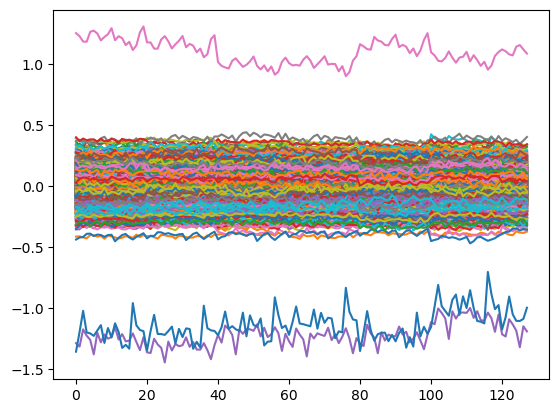

In [18]:
plt.plot(trpb_batch_encoded_mean_all - trpb_batch_encoded_mean_site);

In [14]:
trpb_batch_encoded_mean_all.shape

(128, 1280)

In [7]:
import torch

# Check PyTorch version
print("PyTorch version:", torch.__version__)

# Check CUDA availability
cuda_available = torch.cuda.is_available()
print("CUDA available:", cuda_available)

# If CUDA is available, print CUDA version
if cuda_available:
    cuda_version = torch.version.cuda
    print("CUDA version:", cuda_version)


PyTorch version: 2.1.2+cu121
CUDA available: True
CUDA version: 12.1
